In [ ]:
from bs4 import BeautifulSoup as bs
import requests
import re
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tqdm

In [ ]:
def get_soup(url, parameters=False):
    r = requests.get(url)
    url = r.url
    if parameters:
        main_html = requests.get(url, params=parameters)
    else:
        main_html = requests.get(url=url)
    
    soup = bs(main_html.content, 'html.parser')
    
    return soup

In [3]:
def compute_pages(soup, results_per_page=40):
    
    try:
        items = int(re.search('\d+\s+of\s+(\d+)',soup.find_all(class_='listing-results-utils-count')[0].text).groups()[0])

        pages = math.ceil(items/results_per_page)
    
    except:
        
        return None
    
    return pages

In [4]:
def get_page_postcodes(url, page):
    
    soup = get_soup(url, {'pn':page})
    
    postcodes = [postcodes.get_text().strip(' ,') for postcodes in soup.find_all(class_='sold-prices-street-postcode')]

    return postcodes   

In [5]:
def get_inner_postcodes(postcode):
    
    base_url = 'https://www.zoopla.co.uk/house-prices/browse/london/{pc}'\
               .format(pc=postcode)
        
    n_pages = compute_pages(get_soup(base_url))

    postcodes = []
    
    for page in range(n_pages+1):
        
        postcodes += get_page_postcodes(url=base_url, page=page)

    return set(postcodes)

In [6]:
def extract_properties_from_postcode(postcode):
    
    postcode = postcode.replace(' ', '-')
    
    base_url = 'https://www.zoopla.co.uk/house-prices/london/'
    url = 'https://www.zoopla.co.uk/house-prices/london/{pc}/?pn={page}'.format(pc=postcode, page=1)
    soup = get_soup(url)
    
    n_pages = compute_pages(soup)
    
    if not n_pages:
        return None
    
    results = []
    
    for page in range(1, n_pages+1):
            
        url = 'https://www.zoopla.co.uk/house-prices/london/{pc}/?pn={page}'.format(pc=postcode, page=page)
        soup = get_soup(url)
        propierties = soup.find_all('tr', class_=re.compile('row-(even|odd)'))
            
        for i, row in enumerate(propierties[1:]):

            try:
                
                result = {x:y for x,y in zip(('address', 'date', 'price', 'attributes'), extract_sales_by_row(row))}
                result['postcode'] = postcode    
                
                results.append(result)

            except:
                
                return row
        
    
    return results

In [7]:
def extract_old_prices(panels):
    
    data = panels[0].text.split('\n\n\n')
    
    prices = [data[date].strip() for date in range(0, len(data),2)]
    dates = [data[price].strip() for price in range(1, len(data),2)]
    
    return prices, dates

In [8]:
def extract_sales_by_row(row):

    house = row.findChild(class_='browse-cell-address')
    sales = row.findChild(class_='browse-cell-date')
    attributes = row.findChild(class_='attributes').get_text().strip()

    address = house.findChild(class_='sold-prices-results-address')
    date = sales.findChild(class_='sold-prices-data')
    price = sales.findChild(class_='sold-prices-data-price')
    old_price = sales.findChildren(class_='previous-sales-panel')
    
    if address:
        address = address.get_text().strip().split('\n')[0]
    else:
        address = None
        
    if date:
        date = [date.get_text().strip()]
    else:
        date = None
        
    if price:
        price = [price.get_text().strip()]
    else:
        price = None
    
    if old_price:
        dates, prices = extract_old_prices(old_price)
        prices = price + prices
        dates = date + dates
    else:
        prices = price
        dates = date
        
        
    return address, dates, prices, attributes

In [9]:
def extract_beds(x):
    txt = x['attributes']
    match = re.search('(\d+)\s*Beds?', txt, re.IGNORECASE)
    if match:
        return match.groups()[0]
    else:
        return None

In [10]:
def merge_price_date(x):
    price_date = []
    for price, date in zip(x['price'], x['date']):
        price_date.append(price+'_'+date)
    return price_date

### Sales scraping

In [29]:
def get_sales_historic(postcode):
    
    pc = get_inner_postcodes(postcode)

    total = []

    for postcode in tqdm.tqdm_notebook(pc):
        total.append(extract_properties_from_postcode(postcode))

    df = pd.concat([pd.DataFrame(x) for x in total])
    df = df.dropna()

    df['beds'] = df.apply(extract_beds, axis=1)
    df = df.dropna()
    df['price_date'] = df.apply(merge_price_date, axis = 1) # This is done so it is easier to "melt" the df with the columns at the same time
    df = df.drop(['price', 'date'], axis = 1)
    df = df.reset_index(drop=True)

    df = df.explode('price_date')

    df[['price','date']] = df['price_date'].str.split('_', expand=True) 

    df = df.drop('price_date', axis=1)

    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['price'] = df['price'].str.replace('[£,]', '',regex=True).astype(int)
    sales_df['beds'] = sales_df['beds'].astype(int)

    return df
    

In [28]:
sales_df = get_sales_historic(sales_df)

/home/angel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [31]:
sales_df.head()

,address,attributes,postcode,beds,price,date,year
0,"Flat 4, Elstow Grange 40-42, Brondesbury Park","Flat, Freehold, 3 Beds, 1 Bath, 1 Recep",NW6-7DW,3,140000,1998-11-01,1998
1,"Flat 6, Elstow Grange 40-42, Brondesbury Park","Flat, Leasehold, 3 Beds, 1 Bath, 1 Recep",NW6-7DW,3,400000,2014-01-01,2014
1,"Flat 6, Elstow Grange 40-42, Brondesbury Park","Flat, Leasehold, 3 Beds, 1 Bath, 1 Recep",NW6-7DW,3,245000,2003-07-01,2003
2,"Flat 10, Elstow Grange 40-42, Brondesbury Park","Flat, Leasehold, 4 Beds, 1 Bath, 1 Recep",NW6-7DW,4,405000,2007-08-01,2007
3,"Flat 14, Elstow Grange 40-42, Brondesbury Park","Flat, Leasehold, 2 Beds, 1 Bath, 2 Receps",NW6-7DW,2,410000,2013-10-01,2013


In [32]:
sales_df.to_csv('nw6_data_sale_raw.csv')

In [33]:
outs_sales = sales_df.groupby(["beds","year"])["price"].quantile([0.25, 0.75]).unstack(level=2).reset_index()
outs_sales['IQR'] = outs_sales[0.75] - outs_sales[0.25]



tmp_data = sales_df.merge(on=['year', 'beds'], right=outs_sales)

sales_df_no = tmp_data[~((tmp_data['price'] < tmp_data[0.25] - tmp_data['IQR']) | (tmp_data['price'] > tmp_data[0.75] + tmp_data['IQR']))].drop(['IQR', 0.25, 0.75], axis=1)

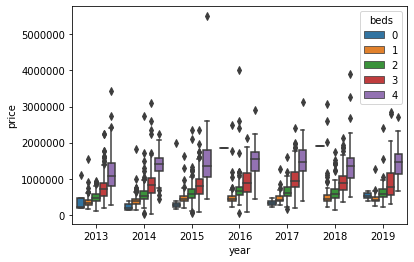

In [34]:
sns.boxplot(data=sales_df[(sales_df['beds']<5)&(sales_df['year']>2012)], y='price',x='year', hue='beds')

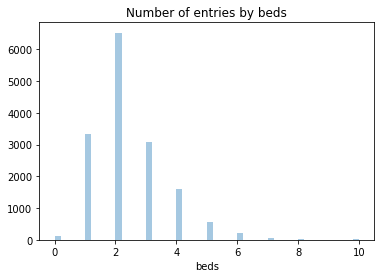

In [35]:
sns.distplot(sales_df['beds'],kde=False)
plt.title('Number of entries by beds')
plt.show()

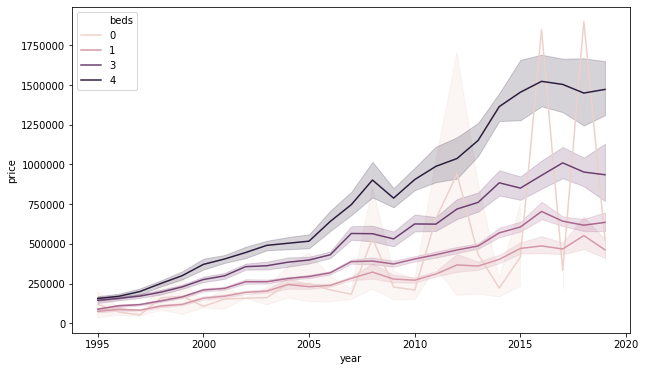

In [36]:
plt.figure(figsize=(10,6))
sns.lineplot(data=sales_df[sales_df['beds']<5], x = 'year', y='price', hue='beds')
plt.legend()
plt.show()

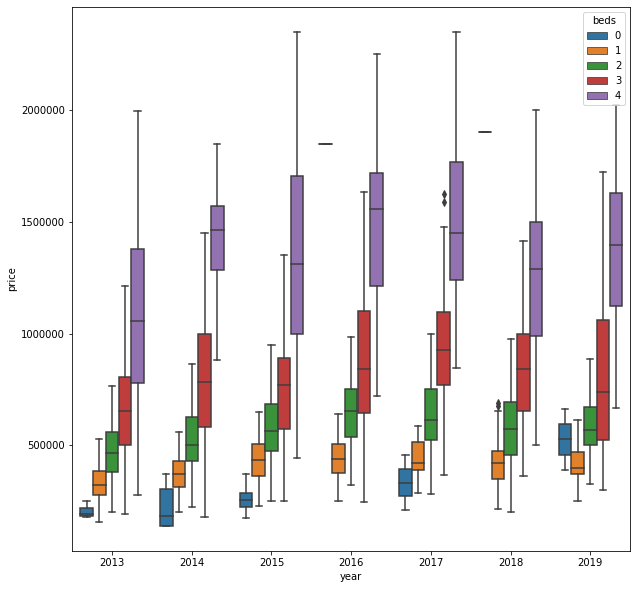

In [37]:
plt.figure(figsize=(10,10))
sns.boxplot(data=sales_df_no[(sales_df_no['beds']<5)&(sales_df_no['year']>2012)], y='price',x='year', hue='beds')

In [38]:
sales_df_no.to_csv('nw6_data_sale.csv')

### Rent scraping

In [45]:
def extract_renting_data_from_panel(wrapper_soup):
    
    main_panel = wrapper_soup.findNext(class_='listing-results-right clearfix')
    
    price = main_panel.find(class_='listing-results-price text-price')
    attrs = main_panel.find(class_='listing-results-attr')
    beds = attrs.find(class_='num-beds')
    baths = attrs.find(class_='num-baths')
    reception = attrs.find(class_='num-reception')
    direction =  main_panel.find(class_='listing-results-address')
    
    listed_panel = wrapper_soup.findNext(class_='listing-results-footer clearfix')
    
    if listed_panel:
        listed = listed_panel.findChild('small').get_text(separator='').strip(' by\n').split('\n')[1]
    else:
        listed = None
    
    attrs2 = attrs.findNextSibling(class_='listing-results-attr')
    
    if attrs2:
        attrs2 = attrs2.findChild('a')
        if attrs2:
            type_ = attrs2.text.strip()
            href = attrs2.attrs['href']
        else:
            type_ = None
            href = None
    
    if price:
        price = price.text.split('pcm')[0].replace('£','').strip()
    else:
        price = None
    
    if beds:
        beds = beds.text.strip()
    else:
        beds = None
    
    if baths: 
        baths = baths.text.strip()
    else:
        baths = None
    
    if reception:
        reception = reception.text.strip()
    else:
        reception = None
    if direction:
        direction = direction.text.strip()
    else:
        direction = None
        
    result = {
        'price':price,
        'beds' : beds,
        'baths': baths,
        'reception': reception,
        'href': href,
        'type' : type_,
        'date':listed,
        'direction':direction
    }

    return result

In [46]:
def get_propierties_from_page(soup):
    
    results = []

    table_rents = soup.findAll(id_='content')

    content = soup.findAll(class_='listing-results')[0]

    propierties = [x for x in content.findAll(class_='listing-results-wrapper')]

    for prop in tqdm.tqdm_notebook(propierties, unit='property'):
        results.append(extract_renting_data_from_panel(prop))
    
    return results

In [47]:
def get_rent_historic(postcode):
    
    results = []
    
    base_url = 'https://www.zoopla.co.uk/to-rent/property/london/{pc}/'\
               .format(pc=postcode)
    
    base_soup = get_soup(base_url, \
                    parameters={'pn':0,'page_size':'100'})
                         
    n_pages = compute_pages(base_soup, 100)
    
    for page in tqdm.tqdm_notebook(range(1, n_pages+1), unit='page'):
        result = get_propierties_from_page(get_soup(base_url, \
                    parameters={'pn':page,'page_size':'100'})) 
        results += result
    
    results = pd.DataFrame(results)
    
    results = results[~results[['price','date','beds']].isna().any(1)]
    results['year'] = results['date'].str[-4:]
    results['beds'] = results['beds'].astype(int)
    results['price'] = results['price'].str.replace(',','').astype(int)
    
    return pd.DataFrame(results)
    

In [48]:
rent_data = get_rent_historic('NW6')

In [50]:
rent_data.to_csv('nw6_data_rent_raw.csv')

In [52]:
outs = rent_data.groupby(["beds","year"])["price"].quantile([0.25, 0.75]).unstack(level=2).reset_index()

tmp_data = rent_data.merge(on=['year', 'beds'], right=outs)
tmp_data['IQR'] = tmp_data[0.75] - tmp_data[0.25]

rent_data_no = tmp_data[~((tmp_data['price'] < tmp_data[0.25]*1.25 - tmp_data['IQR']) | (tmp_data['price'] > tmp_data[0.75]*1.25 + tmp_data['IQR']))].drop(['IQR', 0.25, 0.75], axis=1)

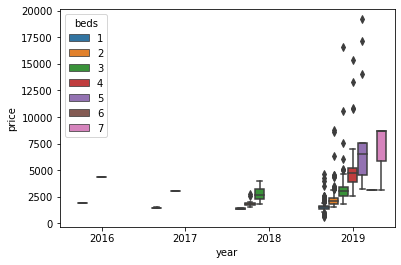

In [53]:
sns.boxplot(data=rent_data, y='price',x='year', hue='beds')

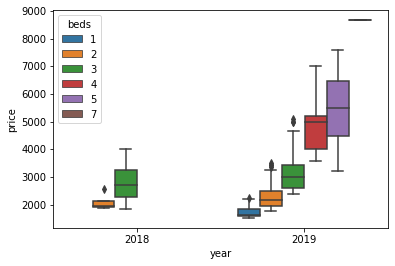

In [54]:
sns.boxplot(data=rent_data_no, y='price',x='year', hue='beds')

In [55]:
rent_data_no.to_csv('nw6_data_rent.csv')

----------

### Aggregated rental prices

In [ ]:
def compute_agg_rental_prices():
    rent_data_agg = pd.read_excel('voa-average-rent-borough.xls', sheet_name='Raw data', \
                              skiprows=2, \
                              usecols=['Year', 'Area', 'Category', 'Count of rents', 'Average'])

    rent_data_agg.head()

    # We filter the data by target region. As the data is not postcode-precise, 
    # the most accurate region would be NW (nortwest)
    rent_data_agg = rent_data_agg[rent_data_agg['Area'] == 'NORTH WEST'].drop('Area', 1)

    rent_data_agg['Category'].unique()

    # We filter by properties having a specific number of rooms
    rent_data_agg = rent_data_agg[~rent_data_agg['Category'].isin(['Room', 'All categories'])]


    beds_dict = {
        'Studio':0,
        'One Bedroom':1,
        'Two Bedroom':2,
        'Three Bedroom':3,
        'Four or more Bedrooms':4,
    }

    rent_data_agg['beds'] = rent_data_agg['Category'].apply(lambda x: beds_dict[x])

    rent_data_agg[['Count of rents', 'Average']] = rent_data_agg[['Count of rents', 'Average']].astype(int)

    rent_data_agg = rent_data_agg.groupby(['Year', 'beds'])['Count of rents', 'Average'].mean().reset_index()

    rent_data_agg.to_csv('rent_data_agg.csv')
    
    return rent_data_agg

### Exploring the rent and sell data OLD

In [ ]:
sns.lineplot(y='yield', x='year', data=full_data)

In [ ]:
sns.lineplot(y='yield', x='year', data=full_data, hue='beds')

We can see something's wierd with the 0-bed segment. 

In [ ]:
full_data.groupby('beds')['price'].agg(['mean', 'std', 'size']).astype(int)

It has a huge std compared to the mean. That's because we they have a very sparese price range and very few sample size. The most reasonable action is to discard them. 

In [ ]:
full_data_no_studio = full_data.loc[full_data['beds']!=0,:]

In [ ]:
plt.figure(figsize=(10,10))
sns.lineplot(y='yield', x='year', data=full_data_no_studio, hue='beds')
plt.show()

We can see some of the trends loom to sharp and unnatural. We will sarch for outliers.

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(data=full_data_no_studio, y = 'price', x='beds', hue='year')

It can be seen that there are some heavy outliers.

In [ ]:
outs = full_data_no_studio.groupby(["beds","year"])["price"].quantile([0.25, 0.75]).unstack(level=2).reset_index()

tmp_data = full_data_no_studio.merge(on=['year', 'beds'], right=outs)

tmp_data['IQR'] = tmp_data[0.75] - tmp_data[0.25]

full_data_no_studio_no = tmp_data[~(tmp_data['price'] < tmp_data[0.25] - tmp_data['IQR']*1.5) | (tmp_data['price'] > tmp_data[0.75] + tmp_data['IQR']*1.5)].drop(['IQR', 0.25, 0.75], axis=1)

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(data=full_data_no_studio_no, y = 'price', x='year', hue='beds')

In [ ]:
import seaborn as sns; sns.set()
sns.palplot(sns.color_palette())

In [ ]:
plt.figure(figsize=(10,10))
sns.lineplot(y='yield', x='year', data=full_data_no_studio_no, hue='beds', style='beds', palette=sns.color_palette()[0:4])
plt.show()

The green spike (2013, 3 beds) it mainly due to some very unrealistic prices (see table below). They do not fall mathematically into an outlier but they are clearly wrong.

In [ ]:
full_data_no_studio_no[(full_data_no_studio_no['beds']==3)&(full_data_no_studio_no['year']==2014)].sort_values(by='price')

In [ ]:
ax = sns.boxenplot(data=full_data_no_studio_no, x='beds', y='yield')
ax.set_ylim([0, 0.06])

In [ ]:
full_data_no_studio_no.groupby( 'beds')['yield'].

In [ ]:
anything above 7% of yield is error and below 1 also.

In [ ]:
full_data_no_studio_no.loc[2647]

In [ ]:
use the robert's data to create and index and adjust to the past the current renting date.

In [ ]:
full_data_no_studio.shape

In [ ]:
full_data_no_studio_no.shape

In [ ]:
1% of cost ratio per calcular els costos pel net.
talk with stpehen about costs